# Прогнозирование стоимости автомобиля по характеристикам

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.metrics import r2_score
import lazypredict
from lazypredict.Supervised import LazyClassifier
from lazypredict.Supervised import LazyRegressor
import warnings
import time
from urllib.error import HTTPError
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# !pip install catboost
# !pip install -U selenium
# !pip install webdriver-manager

## Парсинг

Сначала, со страниц с краткой информацией по авто, парсим ссылки на страницы с подробной. Сохраняем ссылки в файл, чтобы не потерять. Рабочий список ссылок формируется в переменной href. 

In [3]:
'''
pages = 99
href = []
service=Service('d:\chromedriver.exe')
driver = webdriver.Chrome(service=service)
url = "https://auto.ru/moskva/cars/all/"
driver.get(url)
items = driver.find_elements_by_xpath('//a[@class="Link ListingItemTitle__link"]')
for i in range(len(items)):
    href.append(items[i].get_attribute('href'))

for page in range(2, pages):
    url = "https://auto.ru/moskva/cars/all/?page=" + str(page)
    driver.get(url)
    items = driver.find_elements_by_xpath('//a[@class="Link ListingItemTitle__link"]')
    for i in range(len(items)):
        href.append(items[i].get_attribute('href'))
driver.close()

# df = pd.DataFrame(href)
# df.to_csv('links.csv')
'''

'\npages = 99\nhref = []\nservice=Service(\'d:\\chromedriver.exe\')\ndriver = webdriver.Chrome(service=service)\nurl = "https://auto.ru/moskva/cars/all/"\ndriver.get(url)\nitems = driver.find_elements_by_xpath(\'//a[@class="Link ListingItemTitle__link"]\')\nfor i in range(len(items)):\n    href.append(items[i].get_attribute(\'href\'))\n\nfor page in range(2, pages):\n    url = "https://auto.ru/moskva/cars/all/?page=" + str(page)\n    driver.get(url)\n    items = driver.find_elements_by_xpath(\'//a[@class="Link ListingItemTitle__link"]\')\n    for i in range(len(items)):\n        href.append(items[i].get_attribute(\'href\'))\ndriver.close()\n\n# df = pd.DataFrame(href)\n# df.to_csv(\'links.csv\')\n'

Открываем ссылки из href и запускаем функцию разбора и записи содержимого страницы:

In [4]:
'''
cars = []
lst = []
service=Service('d:\chromedriver.exe')
driver = webdriver.Chrome(service=service)
page = []
for url in href:    
    driver.get(str(url))
    # Получаем содержимое html-страницы:
    page = driver.execute_script("return document.body.innerHTML;")
    cars_param(page)
    time.sleep(1)
# Закрываем процесс браузера:
driver.quit()

# df1.to_csv('cars.csv')
'''

'\ncars = []\nlst = []\nservice=Service(\'d:\\chromedriver.exe\')\ndriver = webdriver.Chrome(service=service)\npage = []\nfor url in href:    \n    driver.get(str(url))\n    # Получаем содержимое html-страницы:\n    page = driver.execute_script("return document.body.innerHTML;")\n    cars_param(page)\n    time.sleep(1)\n# Закрываем процесс браузера:\ndriver.quit()\n\n# df1.to_csv(\'cars.csv\')\n'

Функция отлавливает только две версии объявлений (две отличающиеся друг от друга разметки страниц). Есть еще, как минимум одна, версия объявления, но, из-за нехватки времени, она не проработана и игнорируется исключением. Отсюда много некорректной информации в сформированном датасете.

In [5]:
'''
def cars_param(page):
    soup = BeautifulSoup(page, 'html.parser')
    try:
        try:
            param = [child.get_text(' ').replace('\xa0', ' ') for child in soup.find(
                    'ul', class_='CardInfo').children]

            model_name = soup.find('h1', class_='CardHead__title').text
            brand = model_name.split(' ')[0]
            try:
                price = soup.find(
                    'span', class_='OfferPriceCaption__price').text.replace('\xa0', '')
            except:
                price = None
            param = [param.split(' ', 1)[1:] for param in param]
            param = [j for i in param for j in i]
            del param[-1]

            productionDate = param[0].split()[1]
            mileage = param[1].split()[:2]
            mileage = ''.join(mileage)
            bodyType = param[2]
            color = param[3]
            engineDisplacement = param[4].split(
                '/')[0].replace('л', '').replace(' ', '')
            enginePower = param[4].split('/')[1].split()[0]
            fuelType = param[4].split('/')[2].replace(' ', '')
            equipment_dict = param[5]
            tax = param[6].split()[:2]
            tax = ''.join(tax)
            vehicleTransmission = param[7]
            wd = param[8]
            wheel = param[9]
            state = param[10]
            owners = param[11]
            pts = param[12]
            customs = param[13]

        except AttributeError:
            param = [child.get_text(' ').replace('\xa0', ' ') for child in soup.find(
                    'ul', class_='CardInfoGrouped__list').children]

            model_name = soup.find('h1', class_='CardNewHead__title').text
            brand = model_name.split(' ')[0]
            try:
                price = soup.find(
                        'span', class_='OfferPriceCaption__price').text.replace('\xa0', '')
            except:
                price = None

            param = [param.split(' ', 1)[1:] for param in param]
            param = [j for i in param for j in i]

            productionDate = None
            mileage = None
            bodyType = param[0]
            try:
                color = param[6]
            except:
                color = param[5]
            engineDisplacement = param[2].split(
                    '/')[0].replace('л', '').replace(' ', '')
            enginePower = param[2].split('/')[1].split()[0]
            fuelType = param[2].split('/')[2].replace(' ', '')
            equipment_dict = param[1]
            try:
                tax = param[3].split()[:2]
                tax = ''.join(tax)
            except:
                tax = None
            vehicleTransmission = param[4]
            wd = param[5]
            wheel = None
            state = None
            owners = None
            pts = None
            customs = None

        cars1.append({"brand": brand, "model_name": model_name, "bodyType": bodyType, "color": color,
                     "engineDisplacement": engineDisplacement,'enginePower':enginePower,"fuelType":fuelType,\
                     "mileage": mileage,"productionDate":productionDate,"vehicleTransmission":vehicleTransmission,\
                     "owners": owners,"pts":pts,"wd":wd,"wheel":wheel,"state":state, "tax": tax, "customs": customs, "price":price})
    except:
        pass
        
'''

'\ndef cars_param(page):\n    soup = BeautifulSoup(page, \'html.parser\')\n    try:\n        try:\n            param = [child.get_text(\' \').replace(\'\xa0\', \' \') for child in soup.find(\n                    \'ul\', class_=\'CardInfo\').children]\n\n            model_name = soup.find(\'h1\', class_=\'CardHead__title\').text\n            brand = model_name.split(\' \')[0]\n            try:\n                price = soup.find(\n                    \'span\', class_=\'OfferPriceCaption__price\').text.replace(\'\xa0\', \'\')\n            except:\n                price = None\n            param = [param.split(\' \', 1)[1:] for param in param]\n            param = [j for i in param for j in i]\n            del param[-1]\n\n            productionDate = param[0].split()[1]\n            mileage = param[1].split()[:2]\n            mileage = \'\'.join(mileage)\n            bodyType = param[2]\n            color = param[3]\n            engineDisplacement = param[4].split(\n                \'/\')

# Setup

In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.1


In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [9]:
VERSION    = 1
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

In [10]:
%matplotlib inline
# warnings.filterwarnings("ignore")
path = '../ML_2_prj-auto/'

# Kaggle
# DATA_DIR = '/kaggle/input/sf-scoring/'

# pd.set_option('precision', 6)

## Предобработка

In [11]:
# Функция расчета метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def df_describe(df):
    '''
    Вывод статистки
    '''
    desc = df.describe(include='all', percentiles=[
                       0.5]).T  # сохранение отчета от df.describe()
    # получение и сохранение дополнительных статистик/свойств
    desc['type'] = [type(x) for x in df.iloc[0]]  # тип данных
    desc['NaN'] = df.isna().sum()                # количество пропусков
    desc.unique = df.nunique()                   # количество уникальных значений
    # самое распрстроненноё значение
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0]
                 for col in df.columns]  # количество top в признаке
    return desc


def fill_nan(data, col):
    '''
    Функция пропорционального заполнения 
    пропусков 
    '''
    na = data[col].isna().sum()  # фиксируем количество пустых ячеек

    disp = data[col].value_counts()  # расписываем по категориям
    s = disp.sum()
    w = np.zeros(len(disp))  # формируем пустой массив весов

    for i in range(len(disp)):  # расчитваем веса категорий
        w[i] = disp[i]/s

    #  массив с количеством пропусков, пропорционально распределенных между категориями
    w_data = np.uint32(np.array([np.round(x, 0) for x in w * na]))

    #  исправляем ошибки округления
    if np.sum(w_data) < na:
        w_data[0] = w_data[0] + 1
    elif np.sum(w_data) > na:
        w_data[0] = w_data[0] - 1

    #  получаем список индексов пустых ячеек
    to_fill_index = data.loc[data[col].isna()].index

    #  заполняем пустые ячейки номерами соответствующих категорий
    n = 0
    cat = 0
    for w in w_data:
        for i in range(w):
            data[col].loc[to_fill_index[n]] = cat
            n += 1
        cat += 1

    print('было Nan:', na)
    print('было значений в категории:', np.asarray(disp))
    print('стало значений в категории:', np.asarray(disp) + np.asarray(w_data))
    print('разница:', np.asarray(w_data))
    print('стало не Nan:', np.sum(w_data))


# Функция, которая  ищет пересечение уникальных значений признаков
def intersections(col1, col2):
    col1_set = set(col1.astype(str).unique())
    col2_set = set(col2.astype(str).unique())
    intersection = col1_set.intersection(col2_set)
    print(len(col1_set), len(col2_set), len(intersection))


def imputation_numeric(numeric):
    '''Функция заполнения пропущенных значений в числовых признаках'''
    imp_numeric = IterativeImputer(GradientBoostingRegressor())
    imputed = imp_numeric.fit_transform(numeric)
    numeric_imp = pd.DataFrame(
        imputed, columns=numeric.columns, index=numeric.index)
    return numeric_imp


def lble_encod(df, col):
    '''
    Кодирование бинарных признаков
    '''
    label_encoder = LabelEncoder()

    for column in col:
        df[column] = label_encoder.fit_transform(df[column])


def count_plot(column, data):
    '''
    Построение гистограм
    '''
    ax = sns.countplot(x=column, data=data)
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.show()


def graph_plot(column, data):
    '''
    Построение гистограм c боксплотами
    '''
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    data.hist(bins=100)
    plt.title(col)
    plt.subplot(122)
    sns.boxplot(data=data)
    plt.show()

# Data

In [12]:
!ls '../input'

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [13]:
# Kaggle
# train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
# test = pd.read_csv(DIR_TEST+'test.csv')
# train_2022 = pd.read_csv(DIR_TEST+'cars.csv')
# sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

# Загрузка данных
train = pd.read_csv(f'{path}all_auto_ru_09_09_2020.csv')
test = pd.read_csv(f'{path}test.csv')
sample_submission = pd.read_csv(f'{path}sample_submission.csv')

In [14]:
# Загрузка спарсенных 19-2-2022 данных
train_2022 = pd.read_csv(f'{path}cars.csv')

Сводная статистика по датасетам:

In [15]:
df_describe(test)

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
bodyType,34686,24,седан,13147,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
brand,34686,12,BMW,4473,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_url,34686,34686,https://auto.ru/cars/used/sale/audi/100/101694...,1,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
color,34686,16,чёрный,11010,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
complectation_dict,6418,2364,"{""id"":""4562904"",""name"":""Elegance"",""available_o...",51,NaN,NaN,NaN,NaN,NaN,<class 'float'>,28268
description,34686,31732,Выгода до 82 000 руб. при обмене на Ваш автомо...,264,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
engineDisplacement,34686,55,2.0 LTR,7391,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
enginePower,34686,315,249 N12,1708,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
equipment_dict,24690,23705,"{""leather"":true}",108,NaN,NaN,NaN,NaN,NaN,<class 'str'>,9996
fuelType,34686,5,бензин,28601,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0


In [16]:
df_describe(train.drop(['hidden','Состояние'], axis=1))

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
bodyType,89377,168,Внедорожник 5 дв.,31885,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1
brand,89378,36,MERCEDES,8012,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
color,89378,16,040001,25212,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
fuelType,89378,6,бензин,75053,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
modelDate,89377.00,78,2006.00,6138,2008.54,7.42,1904.00,2009.00,2020.00,<class 'numpy.float64'>,1
name,89377,4484,2.0 AT (150 л.с.),1610,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1
numberOfDoors,89377.00,5,5.00,51625,4.51,0.65,0.00,5.00,5.00,<class 'numpy.float64'>,1
productionDate,89378.00,80,2020,12524,2010.83,7.02,1904.00,2011.00,2020.00,<class 'numpy.int64'>,0
vehicleConfiguration,89377,1860,SEDAN MECHANICAL 1.6,4166,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1
vehicleTransmission,89377,4,AUTOMATIC,49218,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1


In [17]:
df_describe(train_2022)

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
Unnamed: 0,3666.00,3666,0,1,1832.50,1058.43,0.00,1832.50,3665.00,<class 'numpy.int64'>,0
brand,3643,57,Kia,831,NaN,NaN,NaN,NaN,NaN,<class 'str'>,23
model_name,3643,780,Hyundai Solaris II Рестайлинг,347,NaN,NaN,NaN,NaN,NaN,<class 'str'>,23
bodyType,3643,21,внедорожник 5 дв.,1139,NaN,NaN,NaN,NaN,NaN,<class 'str'>,23
color,3643,25,чёрный,643,NaN,NaN,NaN,NaN,NaN,<class 'str'>,23
engineDisplacement,3643,51,1.6,1535,NaN,NaN,NaN,NaN,NaN,<class 'str'>,23
enginePower,3666.00,204,123.00,960,160.84,74.36,33.00,140.00,632.00,<class 'numpy.int64'>,0
fuelType,3643,7,Бензин,1979,NaN,NaN,NaN,NaN,NaN,<class 'str'>,23
mileage,2485,1431,142000,13,NaN,NaN,NaN,NaN,NaN,<class 'str'>,1181
productionDate,2485.00,31,2018.00,243,2014.40,4.93,1988.00,2015.00,2022.00,<class 'numpy.float64'>,1181


## Очистка данных

Фомируем списки числовых, категориальных и бинарных признаков.

In [18]:
num_cols = []
cat_cols = []
bin_cols = []

### bodyType

In [19]:
test.bodyType.value_counts()

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
лимузин                        6
седан 2 дв.                    6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

В данных по кузову присутствует количество дверей. В колонке numberOfDoors пропусков нет, поэтому здесь данная информация избыточна.

Удалим разделение кузовов по количеству дверей, объединив купе-хардтоп с купе, седан-хардтоп с седаном, хэтчбек 3 дв. с 5дв и фастбеком.

In [20]:
test.bodyType = test.bodyType.astype('str').apply(
    lambda x: x.split(' ', 1)[0].lower())

In [21]:
test.bodyType = test.bodyType.replace('седан-хардтоп', 'седан')
test.bodyType = test.bodyType.replace('купе-хардтоп', 'купе')
test.bodyType = test.bodyType.replace('фастбек', 'хэтчбек')

In [22]:
test.bodyType.isna().sum()

0

In [23]:
train.bodyType.value_counts()

Внедорожник 5 дв.                    31885
Седан                                30593
Хэтчбек 5 дв.                         8668
Универсал 5 дв.                       3385
Лифтбек                               3121
                                     ...  
Минивэн Emina                            1
Пикап Двойная кабина Crew Cab TRX        1
Универсал 5 дв. California               1
Седан SRT                                1
Седан 120                                1
Name: bodyType, Length: 168, dtype: int64

In [24]:
train.bodyType = train.bodyType.astype('str').apply(
    lambda x: x.split(' ', 1)[0].lower())

In [25]:
train.bodyType = train.bodyType.replace('седан-хардтоп', 'седан')
train.bodyType = train.bodyType.replace('купе-хардтоп', 'купе')
train.bodyType = train.bodyType.replace('фастбек', 'хэтчбек')
train.bodyType = train.bodyType.replace('nan', None)

In [26]:
train.bodyType.isna().sum()

0

In [27]:
train.bodyType = train.bodyType.replace(np.nan, train.bodyType.mode()[0])

In [28]:
train_2022.bodyType.value_counts()

внедорожник 5 дв.       1139
седан                    699
Внедорожник 5 дв.        416
Седан                    342
Хэтчбек 5 дв.            327
хэтчбек 5 дв.            243
лифтбек                  126
универсал 5 дв.           89
Лифтбек                   73
минивэн                   71
компактвэн                39
хэтчбек 3 дв.             25
купе                      24
фургон                     9
внедорожник 3 дв.          6
кабриолет                  4
пикап двойная кабина       4
родстер                    3
седан-хардтоп              2
купе-хардтоп               1
внедорожник открытый       1
Name: bodyType, dtype: int64

In [29]:
train_2022.bodyType = train_2022.bodyType.astype(
    'str').apply(lambda x: x.split(' ', 1)[0].lower())

In [30]:
train_2022.bodyType = train_2022.bodyType.replace('седан-хардтоп', 'седан')
train_2022.bodyType = train_2022.bodyType.replace('купе-хардтоп', 'купе')
train_2022.bodyType = train_2022.bodyType.replace('nan', None)

In [31]:
train_2022.bodyType.isna().sum()

0

In [32]:
train_2022.bodyType = train_2022.bodyType.replace(
    np.nan, train_2022.bodyType.mode()[0])

In [33]:
cat_cols.append('bodyType')

### brand

In [34]:
test.brand.value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

In [35]:
test.brand.isna().sum()

0

In [36]:
train.brand.value_counts()

MERCEDES      8012
BMW           7393
VOLKSWAGEN    7139
NISSAN        5772
HYUNDAI       5734
KIA           5630
TOYOTA        4824
FORD          4797
AUDI          4084
MITSUBISHI    3933
CHEVROLET     3633
OPEL          3114
SKODA         2806
RENAULT       2713
MAZDA         2311
VOLVO         2073
PEUGEOT       1641
LAND_ROVER    1623
HONDA         1179
CITROEN       1146
LEXUS         1054
DAEWOO        1041
INFINITI      1040
SUBARU         932
SUZUKI         872
SSANG_YONG     717
PORSCHE        713
CHERY          566
JEEP           483
GREAT_WALL     420
DODGE          418
CHRYSLER       323
CADILLAC       322
JAGUAR         313
MINI           312
GEELY          295
Name: brand, dtype: int64

In [37]:
train.brand.isna().sum()

0

In [38]:
train_2022.brand.value_counts()

Kia              831
Hyundai          788
Volkswagen       267
Nissan           179
BMW              168
Mercedes-Benz    160
Toyota           133
Skoda            124
Renault           99
Ford              92
Audi              88
LADA              67
Land              67
Mitsubishi        65
Mazda             52
Opel              49
Chevrolet         49
Lexus             36
Volvo             34
Citroen           31
Infiniti          28
Porsche           24
Peugeot           20
Jaguar            18
SsangYong         18
Honda             14
Jeep              14
Subaru            14
MINI              11
Chery             10
Cadillac           9
Daewoo             8
Suzuki             8
Dodge              7
Acura              6
Lifan              5
Great              4
Datsun             4
Haval              4
Brilliance         3
Chrysler           3
BYD                3
Rolls-Royce        3
Tesla              3
Iran               3
ГАЗ                2
Geely              2
SEAT         

In [39]:
train_2022.brand = train_2022.brand.astype('str').apply(lambda x: x.upper())

In [40]:
train_2022.brand = train_2022.brand.replace('SSANGYONG', 'SSANG_YONG')
train_2022.brand = train_2022.brand.replace('LAND', 'LAND_ROVER')
train_2022.brand = train_2022.brand.replace('GREAT', 'GREAT_WALL')
train_2022.brand = train_2022.brand.replace('MERCEDES-BENZ', 'MERCEDES')
train_2022.brand = train_2022.brand.replace('NAN', None)

In [41]:
train_2022.brand.isna().sum()

0

In [42]:
train_2022.brand = train_2022.brand.replace(np.nan, train_2022.brand.mode()[0])

In [43]:
cat_cols.append('brand')

### color

In [44]:
test.color.value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

In [45]:
test.color.isna().sum()

0

In [46]:
train.color.value_counts()

040001    25212
FAFBFB    15824
CACECB    11336
97948F    10819
0000CC     8874
EE1D19     4508
200204     3583
007F00     2598
C49648     1854
22A0F8     1398
DEA522      774
660099      750
FFD600      701
4A2197      606
FF8649      516
FFC0CB       25
Name: color, dtype: int64

In [47]:
color_dict = {'040001': 'чёрный', 'EE1D19': 'красный', '0000CC': 'синий', 'CACECB': 'серебристый',
              '007F00': 'зелёный', 'FAFBFB': 'белый', '97948F': 'серый', '22A0F8': 'голубой',
              '660099': 'пурпурный', '200204': 'коричневый', 'C49648': 'бежевый',
              'DEA522': 'золотистый', '4A2197': 'фиолетовый', 'FFD600': 'жёлтый',
              'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

train['color'].replace(color_dict, inplace=True)

In [48]:
train.color.isna().sum()

0

In [49]:
train_2022.color.value_counts()

чёрный         643
белый          555
серый          363
Белый          267
синий          239
серебристый    225
Чёрный         179
Серый          175
коричневый     149
Серебристый    141
красный        138
Синий          112
Коричневый      96
Красный         77
Бежевый         51
Оранжевый       49
бежевый         46
зелёный         39
голубой         31
пурпурный       19
оранжевый       14
золотистый      12
Голубой         11
фиолетовый       6
жёлтый           6
Name: color, dtype: int64

In [50]:
train_2022.color = train_2022.color.astype('str').apply(lambda x: x.lower())

In [51]:
train_2022.color = train_2022.color.replace('nan', None)

In [52]:
train_2022.color.isna().sum()

0

In [53]:
train_2022.color = train_2022.color.replace(np.nan, train_2022.color.mode()[0])

In [54]:
cat_cols.append('color')

### model_name

In [55]:
test.model_name.value_counts()

OCTAVIA         1418
5ER             1026
LANCER           855
E_KLASSE         809
PASSAT           782
                ... 
SIMPLEX            1
HS                 1
MEGA_CRUISER       1
YARIS_VERSO        1
PLATZ              1
Name: model_name, Length: 544, dtype: int64

In [56]:
test.model_name.isna().sum()

0

In [57]:
train.rename(columns={'model': 'model_name'}, inplace=True)

In [58]:
train.model_name.value_counts()

FOCUS          2467
SOLARIS        1769
5ER            1675
ASTRA          1548
OCTAVIA        1497
               ... 
REGIUSACE         1
TRAVIQ            1
YARIS_VERSO       1
ADMIRAL           1
440               1
Name: model_name, Length: 1086, dtype: int64

In [59]:
train.model_name.isna().sum()

0

In [60]:
train_2022.model_name.value_counts()

Hyundai Solaris II Рестайлинг                347
Kia Rio X IV Рестайлинг                      331
Hyundai Creta II                             200
Kia Sportage IV Рестайлинг                   147
Volkswagen Polo VI                            85
                                            ... 
Land Rover Freelander II Рестайлинг            1
Lexus GX 470 I                                 1
BMW X1 20d I (E84)                             1
Mercedes-Benz GLE Coupe 450 AMG I (C292)       1
LADA (ВАЗ) 2121 (4x4) I Рестайлинг (2020)      1
Name: model_name, Length: 780, dtype: int64

In [61]:
train_2022.model_name = train_2022.model_name.astype(str).apply(
    lambda x: x.split(' ', 1)[-1].split(' ', 1)[0].upper())

In [62]:
train_2022.model_name.value_counts()

RIO           403
SOLARIS       380
CRETA         244
SPORTAGE      179
POLO          141
             ... 
CHALLENGER      1
207             1
ALHAMBRA        1
YARIS           1
3008            1
Name: model_name, Length: 309, dtype: int64

In [63]:
intersections(test.model_name, train_2022.model_name)

544 309 111


In [64]:
train_2022.model_name.isna().sum()

0

In [65]:
cat_cols.append('model_name')

### engineDisplacement

In [66]:
test.engineDisplacement.value_counts()

2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
2.6 LTR      55
 LTR         55
6.0 LTR      53
0.7 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
4.9 LTR       4
1.1 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64

In [67]:
test.engineDisplacement = test.engineDisplacement.apply(
    lambda x: str(x).split(' ', 1)[0])
test.engineDisplacement = test.engineDisplacement.apply(
    lambda x: np.nan if x == '' else x).astype('float64')
test.engineDisplacement.value_counts()

2.00    7391
1.60    4973
3.00    3915
1.80    3349
2.50    2477
2.40    1745
3.50    1710
1.40    1635
1.50     725
1.20     485
4.40     447
2.80     384
4.70     377
1.30     365
5.50     361
4.00     356
3.20     348
4.50     346
2.10     271
3.70     242
2.20     236
4.20     228
1.90     221
2.30     203
2.70     189
3.60     183
5.60     170
5.00     158
5.70     135
2.90     131
4.60     108
3.10      88
4.80      84
1.70      59
1.00      57
3.80      57
2.60      55
6.00      53
0.70      53
3.30      44
3.40      36
4.10      35
4.30      32
5.40      31
6.20      28
5.20      12
5.90      12
6.30       8
5.80       7
6.60       6
1.10       4
4.90       4
3.90       1
5.30       1
Name: engineDisplacement, dtype: int64

In [68]:
test.engineDisplacement.isna().sum()

55

In [69]:
test.engineDisplacement = test.engineDisplacement.replace(
    np.nan, test.engineDisplacement.mode()[0])

In [70]:
train.engineDisplacement.value_counts()

1.6          17032
2.0          13446
1.4           5649
1.8           5102
2.4           3272
             ...  
PHEV             1
Regius           1
Trackhawk        1
e-Golf           1
STi              1
Name: engineDisplacement, Length: 534, dtype: int64

Столбец engineDisplacement является результатом очистки столбцов name и vehicleConfiguration. 

In [71]:
train.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [72]:
train.engineDisplacement = train.engineDisplacement.apply(
    pd.to_numeric, errors='ignore')
train.engineDisplacement.loc[train.engineDisplacement.apply(
    lambda x: isinstance(x, str))]=100
# train.ed = train.ed.str.replace(r'[^0-9.]','', regex=True)
#train.ed = train.ed.str.replace(r'[^\d\.]','', regex=True).fillna('100')
train.engineDisplacement = train.engineDisplacement.apply(
    lambda x: None if x > 6.6 else x)
train.engineDisplacement.value_counts()

1.60    17032
2.00    13446
1.40     5649
1.80     5102
2.40     3272
2.50     2887
1.50     2145
3.00     1171
3.50     1170
2.30      883
1.20      849
1.70      706
1.30      676
3.60      426
4.00      371
3.20      370
0.80      367
2.70      352
2.80      262
4.40      260
1.00      214
2.20      214
4.20      199
5.60      185
4.70      179
3.80      160
6.20      157
3.70      154
5.00      122
4.60      115
3.30      105
3.10       98
5.70       93
5.30       91
0.70       75
1.90       73
1.10       66
2.90       61
3.40       37
5.20       34
2.10       28
4.30       26
6.00       24
2.60       19
5.40       18
4.50       18
4.90        7
5.90        5
5.80        5
4.10        4
6.40        4
4.80        1
3.90        1
Name: engineDisplacement, dtype: int64

In [73]:
intersections(test.engineDisplacement, train.engineDisplacement)

54 54 51


In [74]:
train.engineDisplacement.isna().sum()

29390

В датасете очень много пропусков. Данных для замены в других колонках нет. Заполним пропуски с помощью класса  IterativeImputer библиотеки scikit-learn:

In [75]:
numeric_columns=['enginePower','engineDisplacement']
train_engineDisplacement = imputation_numeric(train[numeric_columns])

In [76]:
train.engineDisplacement = train_engineDisplacement.engineDisplacement

In [77]:
train.engineDisplacement.value_counts()

1.60    17032
2.00    13446
1.40     5649
1.80     5102
2.40     3272
        ...  
4.80        1
1.02        1
2.46        1
1.17        1
2.01        1
Name: engineDisplacement, Length: 167, dtype: int64

In [78]:
train_2022.engineDisplacement.value_counts()

1.6       1535
2.0        842
3.0        222
1.4        171
2.5        166
1.8        103
2.4         92
2.2         67
1.5         61
3.5         61
4.4         31
1.2         25
2.1         24
1.3         23
2.8         18
4.0         16
3.6         16
4.5         15
5.5         13
3.7         11
2.3         11
5.0         10
2.9          9
3.2          9
4.7          9
1.7          9
5.6          9
2.7          8
6.2          5
5.7          5
4.2          5
0.8          5
4.6          4
1.1          3
109.с.       3
3.3          2
4.1          2
351.с.       2
1.0          2
6.0          2
3.8          2
0.7          2
299.с.       2
6.6          2
494.с.       2
4.8          2
3.4          1
5.3          1
6.8          1
2.6          1
795.с.       1
Name: engineDisplacement, dtype: int64

In [79]:
train_2022.engineDisplacement = train_2022.engineDisplacement.apply(
    pd.to_numeric, errors='ignore')
train_2022.engineDisplacement.loc[train_2022.engineDisplacement.apply(
    lambda x: isinstance(x, str))]=100
train_2022.engineDisplacement = train_2022.engineDisplacement.apply(
    lambda x: None if x > 6.6 else x)
train_2022.engineDisplacement.value_counts()

1.60    1535
2.00     842
3.00     222
1.40     171
2.50     166
1.80     103
2.40      92
2.20      67
3.50      61
1.50      61
4.40      31
1.20      25
2.10      24
1.30      23
2.80      18
4.00      16
3.60      16
4.50      15
5.50      13
2.30      11
3.70      11
5.00      10
2.90       9
5.60       9
1.70       9
4.70       9
3.20       9
2.70       8
6.20       5
5.70       5
4.20       5
0.80       5
4.60       4
1.10       3
3.80       2
4.80       2
0.70       2
6.00       2
1.00       2
6.60       2
3.30       2
4.10       2
3.40       1
2.60       1
5.30       1
Name: engineDisplacement, dtype: int64

In [80]:
train_2022.engineDisplacement.isna().sum()

34

In [81]:
train_2022.engineDisplacement = train_2022.engineDisplacement.replace(
    np.nan, train_2022.engineDisplacement.mode()[0])

In [82]:
num_cols.append('engineDisplacement')

### enginePower

In [83]:
test.enginePower.value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
61 N12        1
108 N12       1
630 N12       1
338 N12       1
30 N12        1
Name: enginePower, Length: 315, dtype: int64

In [84]:
test.enginePower = test.enginePower.apply(lambda x: str(x).split(' ', 1)[0])
test.enginePower = test.enginePower.apply(pd.to_numeric, errors='ignore')
test.enginePower = test.enginePower.apply(
    lambda x: np.nan if isinstance(x, str) else x).astype('int')
test.enginePower.value_counts()

249    1708
150    1699
110    1039
170     977
105     955
       ... 
38        1
485       1
324       1
164       1
32        1
Name: enginePower, Length: 315, dtype: int64

In [85]:
test.enginePower.isna().sum()

0

In [86]:
train.enginePower.unique()

array([174.,  90., 136., 101., 133., 150., 115., 137., 112., 230.,  70.,
        88., 100.,  75., 165., 182., 170., 113.,  80.,  54.,  60.,  71.,
       122., 125.,  61., 102., 190., 180., 160., 105., 140., 110., 250.,
       200., 130., 120., 225., 163., 211., 249., 255., 143., 220., 239.,
       265., 116., 193., 177., 240., 245., 204., 340., 300., 233., 310.,
       218., 210., 290., 333., 335., 224., 350., 155., 254., 338., 435.,
       372., 460., 275., 500., 260., 450., 420., 280., 326., 285., 408.,
       271., 272., 270., 238., 252., 610., 525., 430., 367., 605., 560.,
       580., 256., 354., 571., 360., 520., 400., 156., 306., 320., 184.,
       129., 258., 231., 118., 192., 286.,  98., 234., 171.,  46.,  51.,
       407., 530., 313., 235., 381., 462., 197., 109., 609., 544., 445.,
       329., 188., 370., 410., 431., 343., 507., 600., 625., 510., 355.,
       269., 264., 347., 555., 575., 321., 276., 226., 175., 203., 311.,
       215., 322., 309., 185., 564., 330., 304., 40

In [87]:
train.enginePower = train.enginePower.apply(pd.to_numeric, errors='ignore')
train.enginePower = train.enginePower.apply(
    lambda x: np.nan if isinstance(x, str) else x)
train.enginePower = train.enginePower.fillna(np.nan)
train.enginePower = train.enginePower.replace(np.nan, train.enginePower.mean())
train.enginePower = train.enginePower.astype('int')
train.enginePower.value_counts()

150    7058
249    3721
140    2898
105    2360
123    2302
       ... 
402       1
466       1
700       1
437       1
410       1
Name: enginePower, Length: 396, dtype: int64

In [88]:
train.enginePower.isna().sum()

0

In [89]:
train_2022.enginePower.value_counts()

123    960
150    421
110    155
249    116
149     69
      ... 
138      1
195      1
201      1
221      1
625      1
Name: enginePower, Length: 204, dtype: int64

In [90]:
train_2022.enginePower = train_2022.enginePower.astype('int')

In [91]:
train_2022.enginePower.isna().sum()

0

In [92]:
num_cols.append('enginePower')

### fuelType

In [93]:
test.fuelType.value_counts()

бензин     28601
дизель      5800
гибрид       223
электро       55
газ            7
Name: fuelType, dtype: int64

In [94]:
test.fuelType.isna().sum()

0

In [95]:
train.fuelType.value_counts()

бензин       75053
дизель       13907
гибрид         295
электро        111
газ             11
универсал        1
Name: fuelType, dtype: int64

In [96]:
train.fuelType.isna().sum()

0

In [97]:
train.fuelType = train.fuelType.replace('универсал', train.fuelType.mode()[0])

In [98]:
train_2022.fuelType.value_counts()

Бензин                              1979
бензин                              1146
Дизель                               483
дизель                                12
Электро                               10
Бензин,газобаллонноеоборудование       7
Гибрид                                 6
Name: fuelType, dtype: int64

In [99]:
train_2022.fuelType = train_2022.fuelType.str.lower()

In [100]:
train_2022.fuelType = train_2022.fuelType.replace(
    'бензин,газобаллонноеоборудование', 'газ')

In [101]:
train_2022.fuelType.isna().sum()

23

In [102]:
train_2022.fuelType = train_2022.fuelType.replace(
    np.nan, train_2022.fuelType.mode()[0])

In [103]:
cat_cols.append('fuelType')

### mileage

In [104]:
test.mileage.value_counts()

200000    436
150000    382
300000    381
180000    347
250000    346
         ... 
109473      1
299910      1
101253      1
23423       1
73732       1
Name: mileage, Length: 11268, dtype: int64

In [105]:
test.mileage.isna().sum()

0

In [106]:
test.mileage = test.mileage.astype('int')

In [107]:
train.mileage.value_counts()

0         13588
200000     1136
150000     1048
180000      897
160000      860
          ...  
109597        1
103450        1
250898        1
117777        1
573000        1
Name: mileage, Length: 17403, dtype: int64

In [108]:
train.mileage.isna().sum()

0

In [109]:
train.mileage = train.mileage.astype('int')

In [110]:
train_2022.mileage.value_counts()

142000    13
135000    11
137000    11
180000    11
134000    10
          ..
92465      1
65120      1
141377     1
28500      1
14300      1
Name: mileage, Length: 1431, dtype: int64

In [111]:
train_2022.mileage.isna().sum()

1181

In [112]:
train_2022.mileage = train_2022.mileage.apply(pd.to_numeric, errors='ignore')
train_2022.mileage = train_2022.mileage.apply(
    lambda x: np.nan if isinstance(x, str) else x)
train_2022.mileage = train_2022.mileage.fillna(np.nan)
train_2022.mileage = train_2022.mileage.replace(
    np.nan, train_2022.mileage.mean())
train_2022.mileage = train_2022.mileage.astype('int')

In [113]:
num_cols.append('mileage')

### numberOfDoors

In [114]:
test.numberOfDoors.value_counts()

5    18703
4    14126
2     1206
3      650
0        1
Name: numberOfDoors, dtype: int64

In [115]:
test.numberOfDoors.isna().sum()

0

In [116]:
train.numberOfDoors.value_counts()

5.00    51625
4.00    33647
3.00     2211
2.00     1893
0.00        1
Name: numberOfDoors, dtype: int64

In [117]:
train.numberOfDoors.isna().sum()

1

In [118]:
train.numberOfDoors = train.numberOfDoors.fillna(train.numberOfDoors.mean())

In [119]:
train.numberOfDoors = train.numberOfDoors.astype('int')

In [120]:
doors_dict = {  'внедорожник': 5,
                'седан': 4,
                'хэтчбек': 5,
                'лифтбек': 5,
                'универсал': 5,
                'минивэн': 5,
                'компактвэн': 5,
                'купе': 2,
                'фургон': 3,
                'пикап': 4,
                'кабриолет': 2,
                'родстер': 2    
            }

In [121]:
train_2022['numberOfDoors'] = train_2022.bodyType.map(doors_dict)

In [122]:
train_2022.numberOfDoors.value_counts()

5    2572
4    1052
2      33
3       9
Name: numberOfDoors, dtype: int64

In [123]:
train_2022.numberOfDoors = train_2022.numberOfDoors.apply(
    lambda x: None if x == 'nan' else x)

In [124]:
train_2022.numberOfDoors.unique()

array([5, 4, 2, 3], dtype=int64)

In [125]:
train_2022.numberOfDoors.isna().sum()

0

In [126]:
train_2022.numberOfDoors = train_2022.numberOfDoors.astype('int')

In [127]:
cat_cols.append('numberOfDoors')

### productionDate

In [128]:
test.productionDate.value_counts()

2012    2798
2008    2606
2011    2589
2013    2488
2014    2134
        ... 
1936       1
1904       1
1967       1
1960       1
1952       1
Name: productionDate, Length: 69, dtype: int64

Сравним колонки modelDate и productionDate.

In [129]:
print('Корреляция modelDate и productionDate:',
      test.modelDate.corr(test.productionDate))
print('Пропуски в modelDate:', test.modelDate.isna().sum())
print('Пропуски в productionDate:', test.productionDate.isna().sum())
print('Количетство набдюдений в modelDate:',
      test.modelDate.value_counts().sum())
print('Количетство набдюдени в productionDate:',
      test.productionDate.value_counts().sum())

Корреляция modelDate и productionDate: 0.9742932794331378
Пропуски в modelDate: 0
Пропуски в productionDate: 0
Количетство набдюдений в modelDate: 34686
Количетство набдюдени в productionDate: 34686


Колонку modelDate можно удалить без потерь.

In [130]:
test.drop(['modelDate'], inplace=True, axis=1)

In [131]:
train.productionDate.value_counts()

2020    12524
2008     7043
2012     6630
2011     6192
2013     5601
        ...  
1960        1
1955        1
1954        1
1948        1
1949        1
Name: productionDate, Length: 80, dtype: int64

In [132]:
train.productionDate.isna().sum()

0

In [133]:
print('Корреляция modelDate и productionDate:',
      train.modelDate.corr(train.productionDate))

Корреляция modelDate и productionDate: 0.969420514821148


In [134]:
train.drop(['modelDate'], inplace=True, axis=1)

In [135]:
train_2022.productionDate.value_counts()

2018.00    243
2013.00    228
2017.00    209
2012.00    208
2020.00    206
2019.00    184
2021.00    178
2014.00    168
2011.00    148
2016.00    143
2015.00    117
2008.00    110
2010.00     95
2007.00     59
2006.00     53
2009.00     25
2002.00     22
2004.00     18
2005.00     16
2003.00     11
1998.00     10
2001.00      9
2022.00      5
2000.00      5
1996.00      4
1997.00      3
1988.00      2
1999.00      2
1991.00      2
1994.00      1
1992.00      1
Name: productionDate, dtype: int64

In [136]:
train_2022.productionDate.isna().sum()

1181

Заполним пропуски следующим образом. Чтобы не нарушать структуру данных в признаке, распреденим пропуски пропорционально количеству значений в категории.

Для этого найдем доли каждой категории в общем количестве, возьмем общее количество пропусков и умножим на вес каждой категории.

В результате мы получим количество дополнительных не NaN значений пропорционально для каждой категории.

Функция работает с категориями от 0 и далее. Поэтому преобразуем количество дверей в категории:

In [137]:
productionDate_dict = train_2022.productionDate.dropna(
).sort_values(ascending=False).unique()
productionDate_dict = dict(enumerate(productionDate_dict.flatten(), 0))
# поменяем местами ключ-значение
productionDate_dict = {v: k for k, v in productionDate_dict.items()}
# превратим годы выпуска в категории
train_2022.productionDate = train_2022.productionDate.map(productionDate_dict)

In [138]:
fill_nan(train_2022, 'productionDate')
fill_nan(train_2022, 'productionDate')
fill_nan(train_2022, 'productionDate')

было Nan: 1181
было значений в категории: [243 228 209 208 206 184 178 168 148 143 117 110  95  59  53  25  22  18
  16  11  10   9   5   5   4   3   2   2   2   1   1]
стало значений в категории: [246 313 307 295 321 283 246 224 228 251 216 180 140  71 105  53  47  26
  25  16  20  13   7   6   9   4   4   2   2   2   2]
разница: [  3  85  98  87 115  99  68  56  80 108  99  70  45  12  52  28  25   8
   9   5  10   4   2   1   5   1   2   0   0   1   1]
стало не Nan: 1179
было Nan: 2
было значений в категории: [358 336 308 307 304 271 263 248 218 211 173 162 140  87  78  37  32  27
  24  16  15  13   8   7   6   4   3   3   3   1   1]
стало значений в категории: [359 336 308 307 304 271 263 248 218 211 173 162 140  87  78  37  32  27
  24  16  15  13   8   7   6   4   3   3   3   1   1]
разница: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
стало не Nan: 1
было Nan: 1
было значений в категории: [358 336 308 307 304 271 263 248 218 211 173 162 140  87  78  37  32  27

In [139]:
train_2022.productionDate.isna().sum()

0

In [140]:
# заменим обратно категории годами выпуска
productionDate_dict = {v: k for k, v in productionDate_dict.items()}
train_2022.productionDate = train_2022.productionDate.map(productionDate_dict)
train_2022.productionDate.value_counts()

2018.00    358
2013.00    336
2017.00    308
2012.00    307
2020.00    304
2019.00    271
2021.00    263
2014.00    248
2011.00    218
2016.00    211
2015.00    173
2008.00    162
2010.00    140
2007.00     87
2006.00     78
2009.00     37
2002.00     32
2004.00     27
2005.00     24
2003.00     16
1998.00     15
2001.00     13
2022.00     10
2000.00      7
1996.00      6
1997.00      4
1988.00      3
1999.00      3
1991.00      3
1994.00      1
1992.00      1
Name: productionDate, dtype: int64

In [141]:
num_cols.append('productionDate')

### vehicleTransmission

In [142]:
test.vehicleTransmission.value_counts()

автоматическая      19596
механическая         7209
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [143]:
test.vehicleTransmission.isna().sum()

0

In [144]:
vehicleTransmission_dict = {
    'автоматическая': 'AUTOMATIC',
    'механическая': 'MECHANICAL',
    'вариатор': 'VARIATOR',
    'роботизированная': 'ROBOT'
}

In [145]:
test.vehicleTransmission = test.vehicleTransmission.map(
    vehicleTransmission_dict)

In [146]:
train.vehicleTransmission.value_counts()

AUTOMATIC     49218
MECHANICAL    25264
ROBOT          7871
VARIATOR       7024
Name: vehicleTransmission, dtype: int64

In [147]:
train.vehicleTransmission.isna().sum()

1

In [148]:
train.vehicleTransmission = train.vehicleTransmission.replace(
    np.nan, train.vehicleTransmission.mode()[0])

In [149]:
train_2022.vehicleTransmission.value_counts()

автоматическая      1449
Автоматическая       861
механическая         392
роботизированная     248
вариатор             230
Механическая         190
передний              83
Передний              55
полный                55
Вариатор              41
задний                20
Роботизированная      11
0 ₽ / год              4
Левый                  2
7 889 ₽ / год          2
Name: vehicleTransmission, dtype: int64

In [150]:
train_2022.vehicleTransmission = train_2022.vehicleTransmission.astype(
    'str').apply(lambda x: x.lower())

In [151]:
train_2022.vehicleTransmission = train_2022.vehicleTransmission.map(
    vehicleTransmission_dict)

In [152]:
train_2022.vehicleTransmission.isna().sum()

244

In [153]:
train_2022.vehicleTransmission.unique()

array(['ROBOT', 'AUTOMATIC', 'MECHANICAL', 'VARIATOR', nan], dtype=object)

In [154]:
vehicleTransmission_dct = {'AUTOMATIC': 0,
                           'MECHANICAL': 1, 'VARIATOR': 2, 'ROBOT': 3}
train_2022.vehicleTransmission = train_2022.vehicleTransmission.map(
    vehicleTransmission_dct)

In [155]:
fill_nan(train_2022, 'vehicleTransmission')

было Nan: 244
было значений в категории: [2310  582  271  259]
стало значений в категории: [2476  623  290  277]
разница: [166  41  19  18]
стало не Nan: 244


In [156]:
vehicleTransmission_dct = {v: k for k, v in vehicleTransmission_dct.items()}
train_2022.vehicleTransmission = train_2022.vehicleTransmission.map(
    vehicleTransmission_dct)
train_2022.vehicleTransmission.value_counts()

AUTOMATIC     2476
MECHANICAL     623
VARIATOR       290
ROBOT          277
Name: vehicleTransmission, dtype: int64

In [157]:
cat_cols.append('vehicleTransmission')

### Владельцы

In [158]:
test['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [159]:
test['Владельцы'] = test['Владельцы'].apply(
    lambda x: x.split()[0].split('\\')[0]).astype('float')

In [160]:
test.rename(columns={'Владельцы': 'owners'}, inplace=True)

In [161]:
test.owners.value_counts()

3.00    15957
1.00     9459
2.00     9270
Name: owners, dtype: int64

In [162]:
test.owners.isna().sum()

0

In [163]:
train['Владельцы'].unique()

array([ 3.,  1.,  2., nan])

In [164]:
train.rename(columns={'Владельцы': 'owners'}, inplace=True)

In [165]:
train.owners.value_counts()

3.00    36248
2.00    21006
1.00    18536
Name: owners, dtype: int64

In [166]:
train.owners.fillna(np.nan, inplace=True)

In [167]:
train.owners.isna().sum()

13588

In [168]:
train.owners.unique()

array([ 3.,  1.,  2., nan])

In [169]:
train.owners = train.owners.replace('nan', None)

In [170]:
owners_dct = {3: 0, 2: 1, 1: 2}
train.owners = train.owners.map(owners_dct)

In [171]:
fill_nan(train, 'owners')

было Nan: 13588
было значений в категории: [36248 21006 18536]
стало значений в категории: [42747 24772 21859]
разница: [6499 3766 3323]
стало не Nan: 13588


In [172]:
owners_dct = {0: 3, 1: 2, 2: 1}
train.owners = train.owners.map(owners_dct)

In [173]:
train_2022.owners.value_counts()

1 владелец            1194
2 владельца            635
3 или более            490
Оригинал               140
Дубликат                18
Не требует ремонта       6
7 лет и 8 месяцев        1
14 лет и 4 месяца        1
Name: owners, dtype: int64

In [174]:
owners_dict = {
    '1 владелец': 1,
    '2 владельца': 2,
    '3 или более': 3
}
train_2022.owners = train_2022.owners.map(owners_dict)

In [175]:
train_2022.owners.isna().sum()

1347

In [176]:
train_2022.owners.unique()

array([ 2.,  1.,  3., nan])

In [177]:
# train_2022.owners = train_2022.owners.fillna(np.nan)

In [178]:
owners_dct = {1: 0, 2: 1, 3: 2}
train_2022.owners = train_2022.owners.map(owners_dct)

In [179]:
fill_nan(train_2022, 'owners')

было Nan: 1347
было значений в категории: [1194  635  490]
стало значений в категории: [1887 1004  775]
разница: [693 369 285]
стало не Nan: 1347


In [180]:
owners_dct = {0: 1, 1: 2, 2: 3}
train_2022.owners = train_2022.owners.map(owners_dct)

In [181]:
cat_cols.append('owners')

### ПТС

In [182]:
test.rename(columns={'ПТС': 'pts'}, inplace=True)

In [183]:
test.pts.value_counts()

Оригинал    30098
Дубликат     4587
Name: pts, dtype: int64

In [184]:
test.pts.isna().sum()

1

In [185]:
test.pts = test.pts.fillna(test.pts.mode()[0])

In [186]:
train.rename(columns={'ПТС': 'pts'}, inplace=True)

In [187]:
train.pts.value_counts()

ORIGINAL     78597
DUPLICATE    10420
Name: pts, dtype: int64

In [188]:
train.pts.isna().sum()

361

In [189]:
pts_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}

In [190]:
train.pts = train.pts.map(pts_dict)

In [191]:
pts_dct = {'Оригинал': 0, 'Дубликат': 1}
train.pts = train.pts.map(pts_dct)

In [192]:
fill_nan(train, 'pts')

было Nan: 361
было значений в категории: [78597 10420]
стало значений в категории: [78916 10462]
разница: [319  42]
стало не Nan: 361


In [193]:
pts_dct = {0: 'Оригинал', 1: 'Дубликат'}
train.pts = train.pts.map(pts_dct)

In [194]:
train_2022.pts.value_counts()

Оригинал               2256
Растаможен              128
Дубликат                 63
1 владелец                4
1 год и 2 месяца          2
3 года и 9 месяцев        2
2 года и 4 месяца         2
2 месяца                  2
11 месяцев                2
4 года и 8 месяцев        1
3 года и 4 месяца         1
3 года и 6 месяцев        1
6 лет и 8 месяцев         1
5 лет и 10 месяцев        1
2 года и 2 месяца         1
2 владельца               1
9 лет                     1
2 года и 9 месяцев        1
2 года и 1 месяц          1
4 месяца                  1
1 год и 5 месяцев         1
3 или более               1
14 лет и 5 месяцев        1
2 года и 8 месяцев        1
10 месяцев                1
10 лет и 5 месяцев        1
5 лет и 4 месяца          1
5 лет и 9 месяцев         1
1 год и 1 месяц           1
4 года и 6 месяцев        1
8 лет и 3 месяца          1
2 года и 11 месяцев       1
10 лет и 3 месяца         1
Name: pts, dtype: int64

In [195]:
train_2022.pts.isna().sum()

1181

In [196]:
train_2022.pts.loc[(train_2022.pts.isna())] = None

In [197]:
train_2022.pts = train_2022.pts.apply(
    lambda x: x if x == 'Оригинал' else None if x == None else 'Дубликат')

In [198]:
pts_dct = {'Оригинал': 0, 'Дубликат': 1}
train_2022.pts = train_2022.pts.map(pts_dct)

In [199]:
fill_nan(train_2022, 'pts')

было Nan: 1181
было значений в категории: [2256  229]
стало значений в категории: [3328  338]
разница: [1072  109]
стало не Nan: 1181


In [200]:
pts_dct = {0: 'Оригинал', 1: 'Дубликат'}
train_2022.pts = train_2022.pts.map(pts_dct)

In [201]:
bin_cols.append('pts')

### Привод

In [202]:
test.rename(columns={'Привод': 'wd'}, inplace=True)

In [203]:
test.wd.value_counts()

передний    15565
полный      15020
задний       4101
Name: wd, dtype: int64

In [204]:
test.wd.isna().sum()

0

In [205]:
train.rename(columns={'Привод': 'wd'}, inplace=True)

In [206]:
train.wd.value_counts()

передний    47315
полный      35001
задний       7061
Name: wd, dtype: int64

In [207]:
train.wd.isna().sum()

1

In [208]:
train.wd = train.wd.fillna(train.wd.mode()[0])

In [209]:
train_2022.wd.value_counts()

передний              1207
полный                1015
Передний               963
Левый                  157
Полный                 140
задний                  97
Чёрный                  16
Белый                   12
Серебристый              8
Серый                    5
Бежевый                  4
автоматическая           4
Синий                    3
Красный                  3
Коричневый               3
Не требует ремонта       2
вариатор                 2
Оранжевый                1
Правый                   1
Name: wd, dtype: int64

In [210]:
train_2022.wd = train_2022.wd.apply(lambda x: str(x).strip())

In [211]:
train_2022.wd = train_2022.wd.replace('Передний', 'передний')
train_2022.wd = train_2022.wd.replace('Полный', 'полный')

In [212]:
train_2022.wd = train_2022.wd.apply(
    lambda x: x if x in ['передний', 'полный', 'задний'] else None)

In [213]:
train_2022.wd.value_counts()

передний    2170
полный      1155
задний        97
Name: wd, dtype: int64

In [214]:
train_2022.wd.isna().sum()

244

In [215]:
wd_dct = {'передний': 0, 'полный': 1, 'задний': 2}
train_2022.wd = train_2022.wd.map(wd_dct)

In [216]:
fill_nan(train_2022, 'wd')

было Nan: 244
было значений в категории: [2170 1155   97]
стало значений в категории: [2325 1237  104]
разница: [155  82   7]
стало не Nan: 244


In [217]:
wd_dct = {0: 'передний', 1: 'полный', 2: 'задний'}
train_2022.wd = train_2022.wd.map(wd_dct)

In [218]:
cat_cols.append('wd')

### Руль

In [219]:
test.rename(columns={'Руль': 'wheel'}, inplace=True)

In [220]:
test.wheel.value_counts()

Левый     33287
Правый     1399
Name: wheel, dtype: int64

In [221]:
test.wheel.isna().sum()

0

In [222]:
train.rename(columns={'Руль': 'wheel'}, inplace=True)

In [223]:
train.wheel.value_counts()

LEFT     87589
RIGHT     1789
Name: wheel, dtype: int64

In [224]:
wheel_dict = {'LEFT': 'Левый', 'RIGHT': 'Правый'}
train.wheel = train.wheel.map(wheel_dict)

In [225]:
train.wheel.isna().sum()

0

In [226]:
train_2022.wheel.value_counts()

Левый                 2311
Не требует ремонта     158
Правый                   8
передний                 3
полный                   3
3 или более              1
1 владелец               1
Name: wheel, dtype: int64

In [227]:
train_2022.wheel = train_2022.wheel.apply(
    lambda x: x if x in ['Левый', 'Правый'] else None)

In [228]:
train_2022.wheel.isna().sum()

1347

In [229]:
wheel_dict = {'Левый': 0, 'Правый': 1}
train_2022.wheel = train_2022.wheel.map(wheel_dict)

In [230]:
fill_nan(train_2022, 'wheel')

было Nan: 1347
было значений в категории: [2311    8]
стало значений в категории: [3653   13]
разница: [1342    5]
стало не Nan: 1347


In [231]:
wheel_dict = {0: 'Левый', 1: 'Правый'}
train_2022.wheel = train_2022.wheel.map(wheel_dict)

In [232]:
bin_cols.append('wheel')

### Таможня

В датасетах в данном столбце содержится только одно знаечение: Растаможен. Поэтому данный признак можно удалить, как не влияющий на целевую переменную.

In [233]:
test.drop(['Таможня'], inplace=True, axis=1)
train.drop(['Таможня'], inplace=True, axis=1)
train_2022.drop(['customs'], inplace=True, axis=1)

### Состояние

В датасетах в данном столбце содержится только либо одно значение (Не требует ремонта), либо пустые строки. Поэтому данный признак можно удалить, как не влияющий на целевую переменную.

In [234]:
test.drop(['Состояние'], inplace=True, axis=1)
train.drop(['Состояние'], inplace=True, axis=1)
train_2022.drop(['state'], inplace=True, axis=1)

### Владение

Признак 'Владение' содержит очень большое количество пропусков в обоих датасетах. Кроме того, он период с даты выпуска до даты публикации объявления, т.е. коррелирует с датой выпуска. Удаляем данный признак.

In [235]:
test.drop(['Владение'], inplace=True, axis=1)
train.drop(['Владение'], inplace=True, axis=1)

### vendor

Данный признак присутствует только в датасете test. В других датасетах его можно создать написав словари для каждого бренда. Однако, признак отражает ту же информацию, что и бренд, только урезанную до бинарного формата. Удаляем данный признак. 

In [236]:
test.drop(['vendor'], inplace=True, axis=1)

### car_url

Данный признак присутствует только в датасете test. Важной информации он не несет. 

In [237]:
test.drop(['car_url'], inplace=True, axis=1)

### model_info

Признак содержит в себе название модели. Удаляем его.

In [238]:
test.drop(['model_info'], inplace=True, axis=1)

### image

Данный признак присутствует только в датасете test. Пригодной к применению информации он не несет.

In [239]:
test.drop(['image'], inplace=True, axis=1)

### priceCurrency

Данный признак присутствует только в датасете test. Содержит в себе только одно значение. Удаляем признак.

In [240]:
test.drop(['priceCurrency'], inplace=True, axis=1)

### vehicleConfiguration

В обоих датасетах признак содержит информацию о кузове, количестве дверей, трансмиссии и литраже. Все эти данные уже имеются в других признаках. Удаляем столбец.

In [241]:
test.drop(['vehicleConfiguration'], inplace=True, axis=1)
train.drop(['vehicleConfiguration'], inplace=True, axis=1)

### name

В обоих датасетах признак содержит информацию об объеме двигателя и мощности. Все эти данные уже имеются в других признаках. Удаляем столбец.

In [242]:
test.drop(['name'], inplace=True, axis=1)
train.drop(['name'], inplace=True, axis=1)

### sell_id

Данный признак не содержит полезной инфрмации. Удаляем.

In [243]:
test.drop(['sell_id'], inplace=True, axis=1)

### description

В обоих датасетах признак содержит, в основном, повторяющуюся рекламную информацию. Удаляем.

In [244]:
test.drop(['description'], inplace=True, axis=1)
train.drop(['description'], inplace=True, axis=1)

### complectation_dict, Комплектация, equipment_dict, super_gen

В данных столбцах содержится информация об оснащении автомобиля и доп.опциях. Обработка данных требует трудозатрат, сопоставимых с выполнением отдельного проекта. В рамках данной работы столбцы удаляем.

In [245]:
test.drop(['complectation_dict'], inplace=True, axis=1)
test.drop(['equipment_dict'], inplace=True, axis=1)
test.drop(['super_gen'], inplace=True, axis=1)
train.drop(['Комплектация'], inplace=True, axis=1)

### parsing_unixtime, hidden, start_date

In [246]:
test.drop(['parsing_unixtime'], inplace=True, axis=1)
train.drop(['hidden'], inplace=True, axis=1)
train.drop(['start_date'], inplace=True, axis=1)

### tax, Unnamed: 0

Есть только в спарсеном датасете. Удаляем.

In [247]:
train_2022.drop(['tax'], inplace=True, axis=1)

In [248]:
train_2022.drop(['Unnamed: 0'], inplace=True, axis=1)

### price

In [251]:
train.price.isna().sum()

410

In [252]:
train = train.loc[~(train.price.isna())]

In [253]:
train.price.value_counts()

450000.00     1212
350000.00     1045
250000.00      994
550000.00      967
650000.00      942
              ... 
2026467.00       1
309999.00        1
4052800.00       1
2996000.00       1
3670000.00       1
Name: price, Length: 8168, dtype: int64

In [254]:
train.price.astype('int')

0         200000
1          60000
2          99000
3          65000
4         100000
          ...   
89373     450000
89374     485000
89375    1090000
89376    1180000
89377    1075000
Name: price, Length: 88968, dtype: int32

In [255]:
train_2022.price.value_counts()

2129900₽       17
1465900₽       16
1245000₽       14
650000₽        13
1195000₽       12
               ..
от 1880900₽     1
1919000₽        1
6056000₽        1
3790000₽        1
925000₽         1
Name: price, Length: 1581, dtype: int64

In [256]:
train_2022 = train_2022.loc[~(train_2022.price.isna())]

In [257]:
# приведем целевую переменную к числовому типу
train_2022.price = train_2022.price.apply(lambda x: str(x))
train_2022.price = train_2022.price.apply(
    lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

In [258]:
train_2022.price.value_counts()

1130000     18
2129900     17
1465900     16
1195000     15
1245000     14
            ..
8200000      1
3045000      1
11295000     1
2180000      1
1024000      1
Name: price, Length: 1523, dtype: int64

In [259]:
train_2022.price.isna().sum()

0

## Feacher engineering

Создадим признак 'возраст автомобиля'. Назовем его 'age'.

In [260]:
test['age'] = 2020 - test.productionDate
train['age'] = 2020 - train.productionDate
train_2022['age'] = 2022 - train_2022.productionDate

<AxesSubplot:>

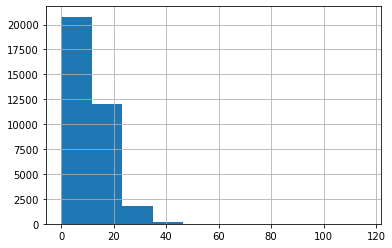

In [261]:
test.age.hist()

<AxesSubplot:>

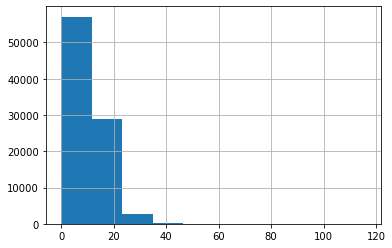

In [262]:
train.age.hist()

<AxesSubplot:>

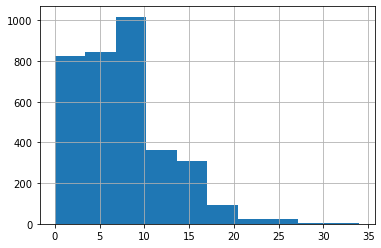

In [263]:
train_2022.age.hist()

In [264]:
num_cols.append('age')

Все датасеты содержат одинаковые столбцы, кроме price, отсутствующий в test.

In [265]:
set(train.columns).difference(test.columns)

{'price'}

In [266]:
set(train_2022.columns).difference(train.columns)

set()

In [267]:
set(train.columns).difference(train_2022.columns)

set()

Добавим столбец price в test с нулевыми значениями.

In [268]:
test['price'] = 0

In [269]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88968 entries, 0 to 89377
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             88968 non-null  object 
 1   brand                88968 non-null  object 
 2   color                88968 non-null  object 
 3   fuelType             88968 non-null  object 
 4   numberOfDoors        88968 non-null  int32  
 5   productionDate       88968 non-null  int64  
 6   vehicleTransmission  88968 non-null  object 
 7   engineDisplacement   88968 non-null  float64
 8   enginePower          88968 non-null  int32  
 9   mileage              88968 non-null  int32  
 10  wd                   88968 non-null  object 
 11  wheel                88968 non-null  object 
 12  owners               88968 non-null  int64  
 13  pts                  88968 non-null  object 
 14  price                88968 non-null  float64
 15  model_name           88968 non-null 

In [270]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  object 
 1   brand                34686 non-null  object 
 2   color                34686 non-null  object 
 3   engineDisplacement   34686 non-null  float64
 4   enginePower          34686 non-null  int32  
 5   fuelType             34686 non-null  object 
 6   mileage              34686 non-null  int32  
 7   model_name           34686 non-null  object 
 8   numberOfDoors        34686 non-null  int64  
 9   productionDate       34686 non-null  int64  
 10  vehicleTransmission  34686 non-null  object 
 11  owners               34686 non-null  float64
 12  pts                  34686 non-null  object 
 13  wd                   34686 non-null  object 
 14  wheel                34686 non-null  object 
 15  age                  34686 non-null 

In [271]:
test.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'model_name', 'numberOfDoors', 'productionDate',
       'vehicleTransmission', 'owners', 'pts', 'wd', 'wheel', 'age', 'price'],
      dtype='object')

Изменим порядок столбцов:

In [273]:
train_2022 = train_2022[['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
                         'fuelType', 'mileage', 'model_name', 'numberOfDoors', 'productionDate',
                         'vehicleTransmission', 'owners', 'pts', 'wd', 'wheel', 'age', 'price']]

In [274]:
train_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3508 entries, 0 to 3665
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             3508 non-null   object 
 1   brand                3508 non-null   object 
 2   color                3508 non-null   object 
 3   engineDisplacement   3508 non-null   float64
 4   enginePower          3508 non-null   int32  
 5   fuelType             3508 non-null   object 
 6   mileage              3508 non-null   int32  
 7   model_name           3508 non-null   object 
 8   numberOfDoors        3508 non-null   int32  
 9   productionDate       3508 non-null   float64
 10  vehicleTransmission  3508 non-null   object 
 11  owners               3508 non-null   int64  
 12  pts                  3508 non-null   object 
 13  wd                   3508 non-null   object 
 14  wheel                3508 non-null   object 
 15  age                  3508 non-null   f

## Удаление дубликатов

In [275]:
print(sum(train.duplicated()))

6436


In [276]:
print(sum(test.duplicated()))

152


In [277]:
print(sum(train_2022.duplicated()))

846


In [278]:
train.drop_duplicates(inplace=True)
train_2022.drop_duplicates(inplace=True)

В тестовом датасете сокращать количество наблюдений нельзя.

## Учет роста стоимость автомобилей

Тестовый и тренеровочный датасеты были формированы в 2020 году. Новые данные были получены в феврале 2022 года. За этот период цены значительно изменились. 

Расчитаем поправку исходя из средних цен по моделям:

In [279]:
brands = train_2022.brand.unique()

In [280]:
inf = []
for brand in brands:
    price_2022 = train_2022[train_2022['brand'] == brand].price.mean()
    price_2020 = train[train['brand'] == brand].price.mean()
    inf.append((price_2022 - price_2020)/price_2020)

In [281]:
inf_mean = np.nanmean(inf)

In [282]:
train_2022.price = train_2022.price.apply(lambda x: round(x / (1+inf_mean), 0))

In [283]:
train_2022.price.mean()

1027307.6686701728

In [284]:
train.price.mean()

1143629.240161392

## Объединение датасетов

In [285]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
train_2022['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
data = data.append(train_2022, sort=False).reset_index(drop=True)  # объединяем

In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119880 entries, 0 to 119879
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             119880 non-null  object 
 1   brand                119880 non-null  object 
 2   color                119880 non-null  object 
 3   engineDisplacement   119880 non-null  float64
 4   enginePower          119880 non-null  int32  
 5   fuelType             119880 non-null  object 
 6   mileage              119880 non-null  int32  
 7   model_name           119880 non-null  object 
 8   numberOfDoors        119880 non-null  int64  
 9   productionDate       119880 non-null  float64
 10  vehicleTransmission  119880 non-null  object 
 11  owners               119880 non-null  float64
 12  pts                  119880 non-null  object 
 13  wd                   119880 non-null  object 
 14  wheel                119880 non-null  object 
 15  age              

## Бинарные признаки

In [287]:
bin_cols

['pts', 'wheel']

Преобразуем значения бинарных признаков в числа:

In [288]:
lble_encod(data, bin_cols)

In [289]:
data

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,vehicleTransmission,owners,pts,wd,wheel,age,price,sample
0,лифтбек,SKODA,синий,1.20,105,бензин,74000,OCTAVIA,5,2014.00,ROBOT,3.00,1,передний,0,6.00,0.00,0
1,лифтбек,SKODA,чёрный,1.60,110,бензин,60563,OCTAVIA,5,2017.00,MECHANICAL,1.00,1,передний,0,3.00,0.00,0
2,лифтбек,SKODA,серый,1.80,152,бензин,88000,SUPERB,5,2014.00,ROBOT,1.00,1,передний,0,6.00,0.00,0
3,лифтбек,SKODA,коричневый,1.60,110,бензин,95000,OCTAVIA,5,2014.00,AUTOMATIC,1.00,1,передний,0,6.00,0.00,0
4,лифтбек,SKODA,белый,1.80,152,бензин,58536,OCTAVIA,5,2012.00,AUTOMATIC,1.00,1,передний,0,8.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119875,седан,KIA,серый,2.00,150,бензин,106812,K5,4,2022.00,AUTOMATIC,3.00,0,передний,1,0.00,1401650.00,1
119876,хэтчбек,RENAULT,белый,1.40,75,бензин,117620,SANDERO,5,2012.00,MECHANICAL,3.00,1,передний,0,10.00,226895.00,1
119877,хэтчбек,CITROEN,серебристый,1.40,90,бензин,88373,C3,5,2009.00,ROBOT,1.00,1,передний,0,13.00,197325.00,1
119878,седан,KIA,серый,2.50,194,бензин,106812,K5,4,2022.00,AUTOMATIC,3.00,0,передний,1,0.00,1467295.00,1


### Значимость бинарных признаков

<AxesSubplot:>

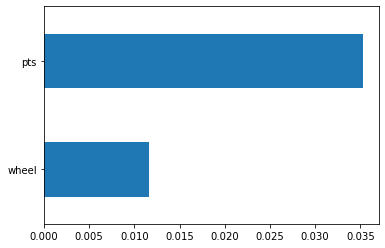

In [290]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols], data['price'],
                                        discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

## Категориальные признаки

In [291]:
cat_cols

['bodyType',
 'brand',
 'color',
 'model_name',
 'fuelType',
 'numberOfDoors',
 'vehicleTransmission',
 'owners',
 'wd']

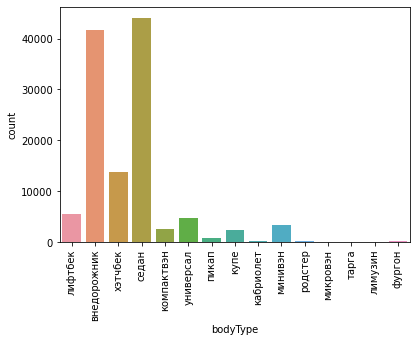

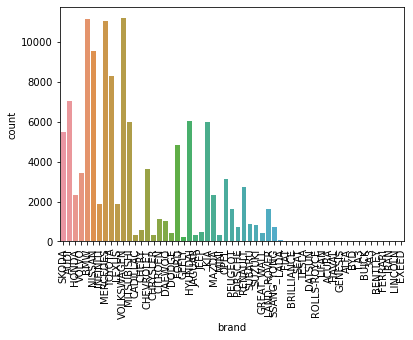

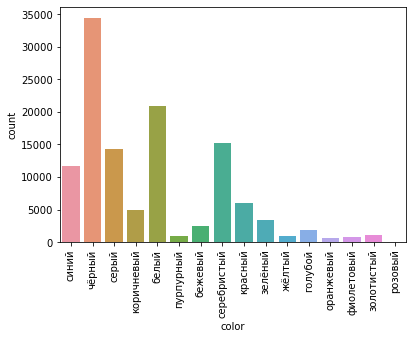

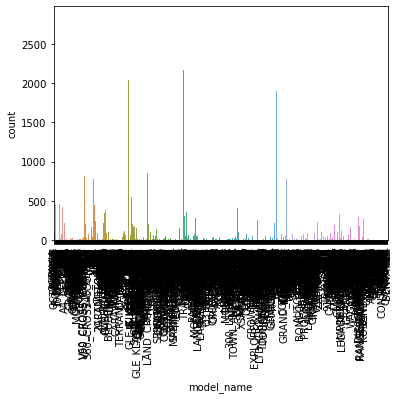

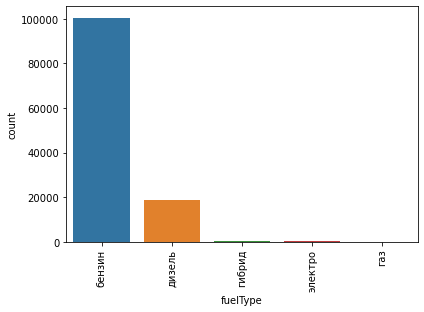

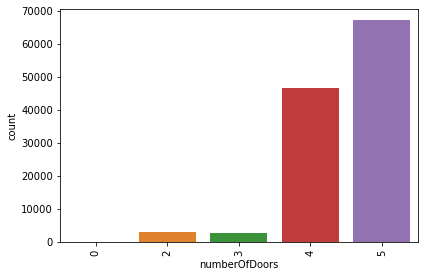

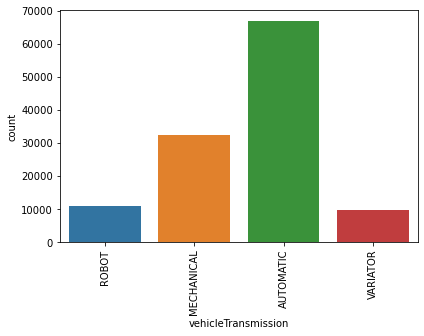

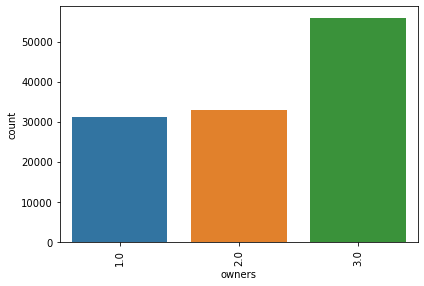

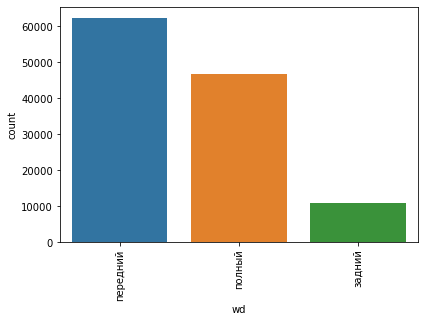

In [292]:
for col in cat_cols:
    count_plot(data[col], data)

In [293]:
lble_encod(data, cat_cols)

### Значимость категорийных признаков

<AxesSubplot:>

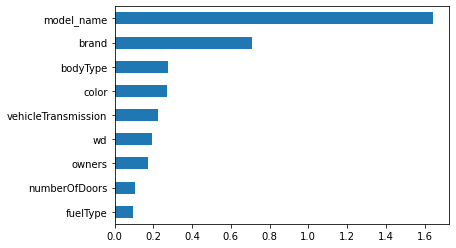

In [294]:
imp_cat = pd.Series(mutual_info_classif(data[cat_cols], data['price'],
                                        discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

## Числовые признаки

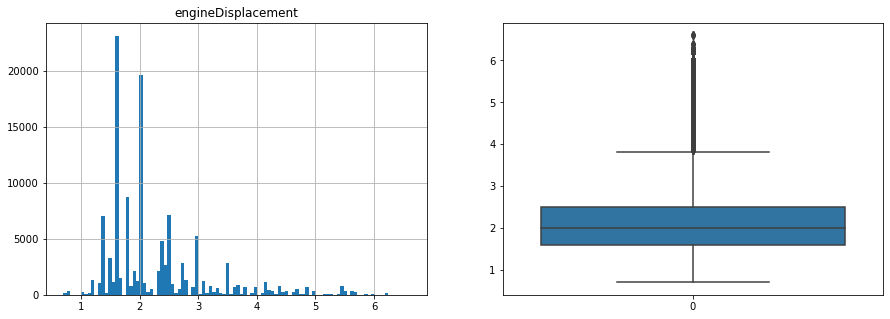

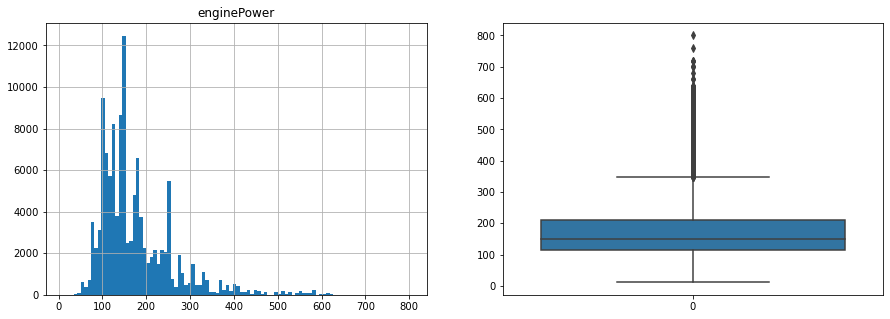

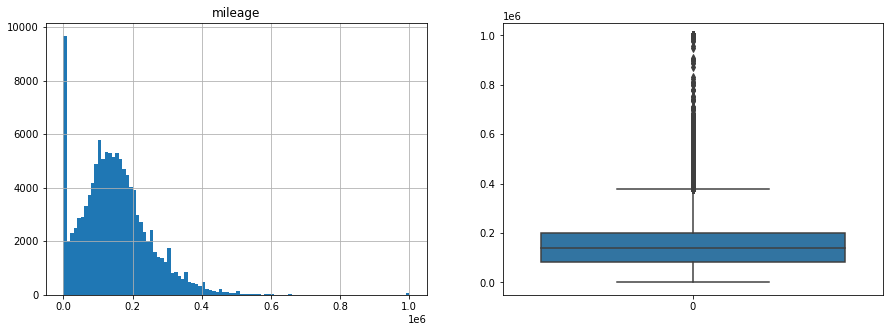

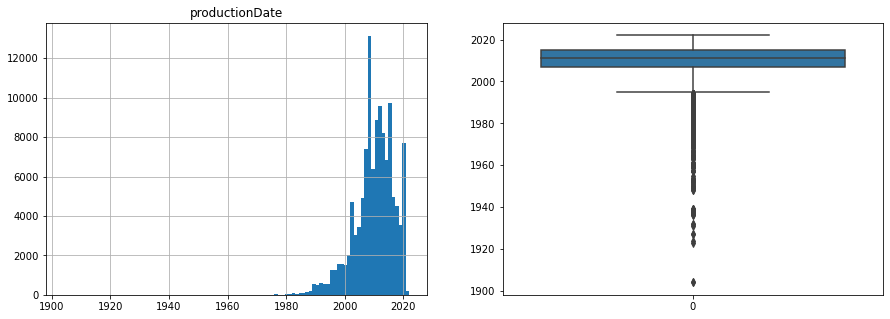

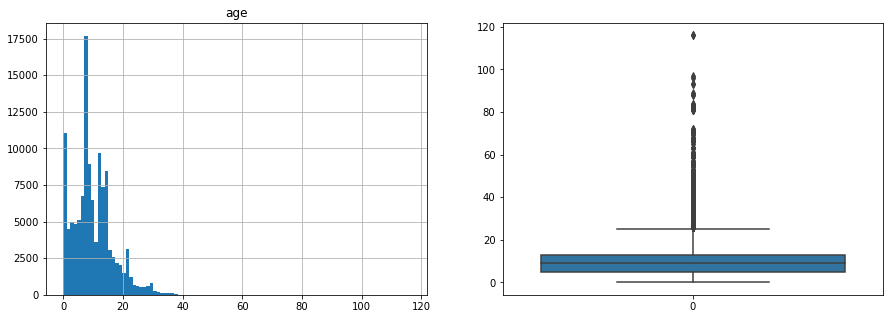

In [295]:
for col in num_cols:
    graph_plot(col, data[col])

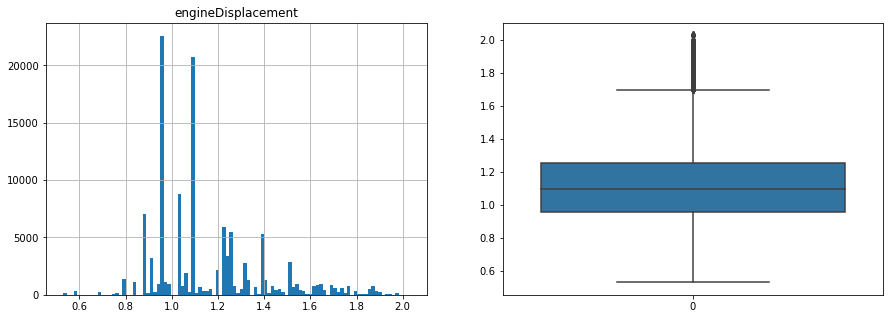

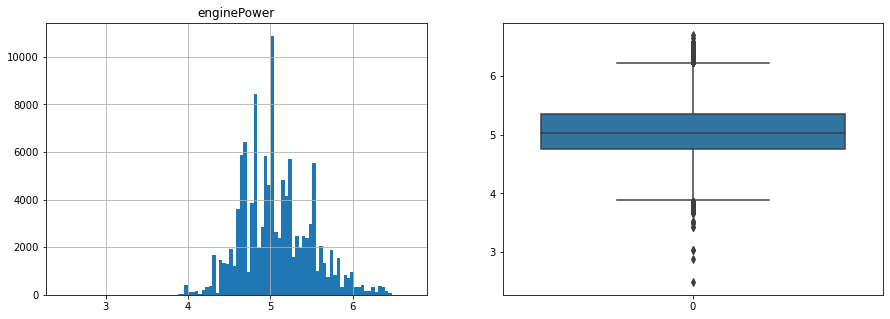

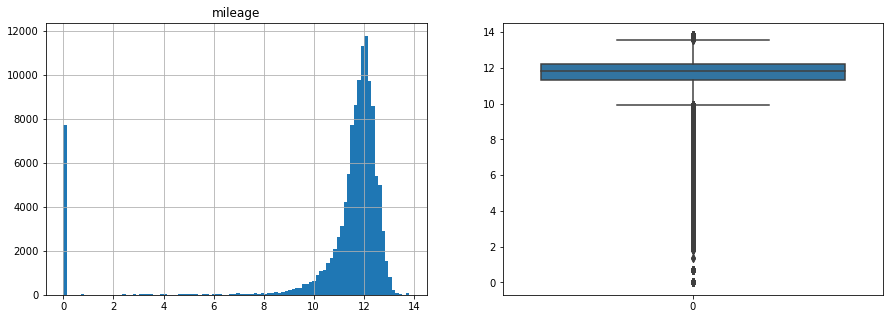

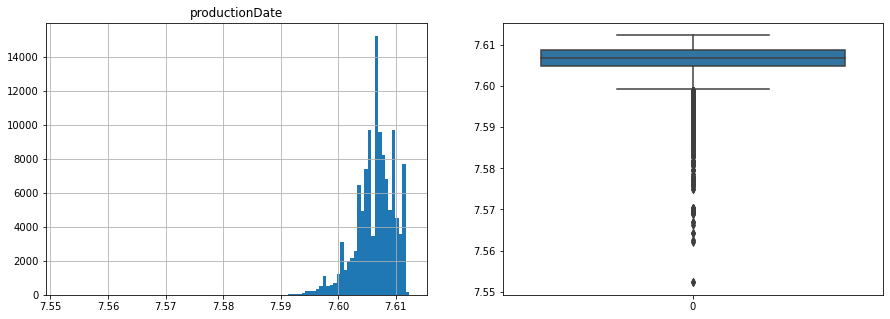

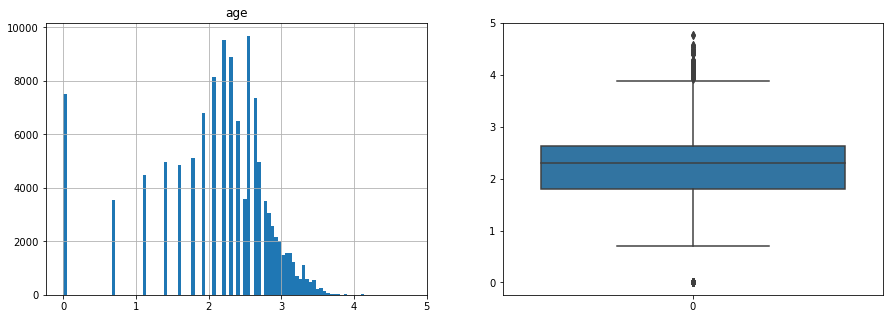

In [296]:
for col in num_cols:
    graph_plot(col, np.log(data[col]+1))

Логарифрмирование очищает признаки от выбросов и нормализует их распределение. Однако, в данном проекте преобразование признаков делать не будем.

### Корреляция числовых признаков

<AxesSubplot:>

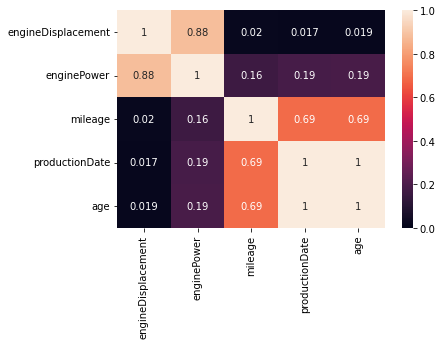

In [297]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Вполне закономерно проявляется относительно высокая корреляция между мощностью и объемом двигателя, а также между пробегом и возрастом. 

В связи с ограниченностью времени проблему мультиколлинеарности в этом проекте решать не будем.

### Значимость числовых признаков

<AxesSubplot:>

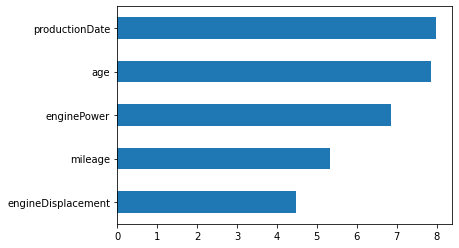

In [298]:
imp_num = pd.Series(f_classif(data[num_cols], data['price'])[
                    0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [299]:
# Сохраним очищенные данные, чтобы не проводить обработку заново, если что
#test.to_csv('test_backup.csv', index=False)
#train.to_csv('train_backup.csv', index=False)
#train_2022.to_csv('train_2022_backup.csv', index=False)

## Обучение

In [300]:
df = data.query('sample == 1').drop(['sample'], axis=1)
X_test = data.query('sample == 0').drop(['sample', 'price'], axis=1).values

In [301]:
train, validation = train_test_split(
    df, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
X_train = train.drop(['price'], axis=1).values
y_train = train['price'].values
X_validation = validation.drop(['price'], axis=1).values
y_true = validation['price'].values

In [302]:
# Выгрузка датасетов в DataSphere для подбора параметров и стекинга.
# Для персонального компьютера - это слишком сложная задача.

In [303]:
#pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
#pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
#pd.DataFrame(X_validation).to_csv('X_validation.csv', index=False)
#pd.DataFrame(y_true).to_csv('y_true.csv', index=False)

### CatBoost

У нас в данных много категориальных признаков. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**


#### Fit

In [304]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_validation, y_true),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [305]:
# оцениваем точность
predict = model.predict(X_validation)
print(f"Точность модели по метрике MAPE: {(mape(y_true, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 16.71%


#### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [306]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_validation, np.log(y_true)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [307]:
VERSION = 1
predict_test = np.exp(model.predict(X_validation))
predict_submission = np.exp(model.predict(X_test))

In [308]:
print(
    f"Точность модели по метрике MAPE: {(mape(y_true, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 13.44%


In [309]:
print(
    f"Точность модели по метрике RMSE: {(RMSE(y_true, predict_test,squared=False)):0.2f}")
print(
    f"Точность модели по метрике R2: {(r2_score(y_true, predict_test)):0.2f}")

Точность модели по метрике RMSE: 350820.19
Точность модели по метрике R2: 0.95


### Lazy Predict

In [ ]:
# !pip install --user lazypredict

Посмотрим, какие модели порекомендует пакет Lazy Predict. Работает данный модуль довольно долго, поэтому прикладываем здесь скриншот с результатами.

In [ ]:
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models,predictions = reg.fit(X_train, X_validation, y_train, y_true)
# print(models)

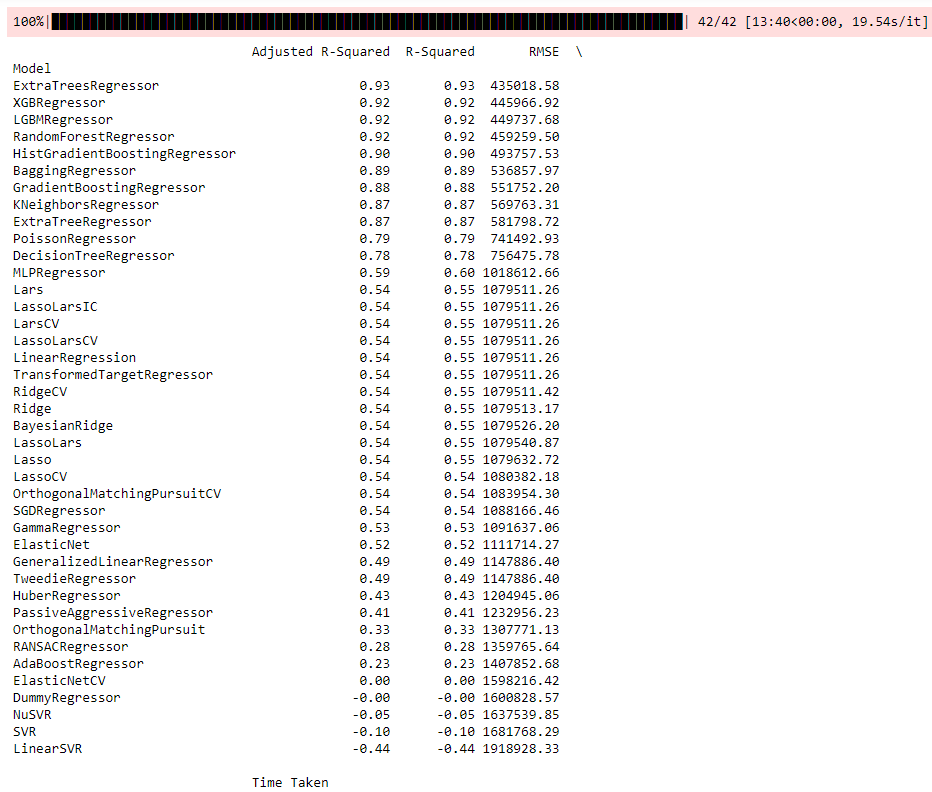

### ExtraTreesRegressor

In [310]:
VERSION = 2
et = ExtraTreesRegressor(random_state=RANDOM_SEED,
                         n_jobs=-1, verbose=1).fit(X_train, np.log(y_train))
predict_submission = np.exp(et.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_true, np.exp(et.predict(X_validation)))) * 100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Точность модели по метрике MAPE: 14.49%


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


### RandomForestRegressor

In [311]:
VERSION = 3
rf = RandomForestRegressor(random_state=RANDOM_SEED,
                           n_jobs=-1, verbose=1).fit(X_train, np.log(y_train))
predict_submission = np.exp(rf.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_true, np.exp(rf.predict(X_validation)))) * 100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Точность модели по метрике MAPE: 14.16%


### XGBRegressor

In [312]:
VERSION = 4
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                      learning_rate=0.03, max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
predict_test = np.exp(xb.predict(X_validation))
predict_submission = np.exp(xb.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_true, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 12.93%


### RandomForestRegressor с подобром параметров

Оптимизируем параметры для RandomForestRegressor. 

Данная задача сложна для ПК, колаб и пр. Поэтому такие "тяжелевосеные" расчеты проводились в DataSphere от Yandex. Здесь приводятся только скриншоты с результатами.

In [314]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num=30)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
#rf = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
#rf_random.fit(X_train, y_train)

In [ ]:
#rf_random.best_params_

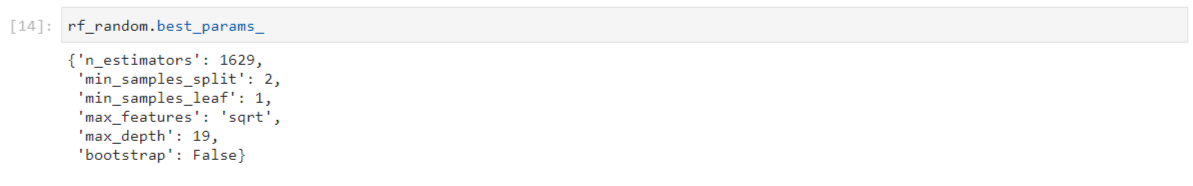

In [316]:
VERSION = 5
rf = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                           max_features='sqrt', max_depth=19, bootstrap=False, random_state=RANDOM_SEED).fit(X_train, np.log(y_train))
predict_submission = np.exp(rf.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_true, np.exp(rf.predict(X_validation)))) * 100:0.2f}%")

Точность модели по метрике MAPE: 13.72%


### GradientBoostingRegressor с подобром параметров

Подбор параметров для GradientBoostingRegressor также проводился в DataSphere от Yandex. Здесь приводится только скриншот с результатами.

In [ ]:
n_estimators = [100, 200, 1000]
learning_rate = [0.01, 0.02, 0.03, 0.04]
max_depth = [5, 10, 15]
min_samples_split = [2, 5, 10]

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split
               }

In [ ]:
#gb = GradientBoostingRegressor(random_state=RANDOM_SEED)
#gb_random = RandomizedSearchCV(estimator=gb, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
#gb_random.fit(X_train, y_train)

In [ ]:
#gb_random.best_params_

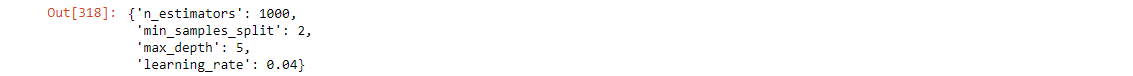

In [317]:
VERSION = 6
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.04,
                               max_depth=5, n_estimators=1000).fit(X_train, np.log(y_train))
predict_submission = np.exp(gb.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_true, np.exp(gb.predict(X_validation)))) * 100:0.2f}%")

Точность модели по метрике MAPE: 14.64%


### Стекинг

Стекинг проводился в DataSphere от Yandex. Здесь приводится только скриншот с результатами.

In [ ]:
VERSION = 7
'''
estimators = [('gb', GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300)),
              ('rf', RandomForestRegressor(random_state = RANDOM_SEED, n_jobs=-1, verbose=1, max_depth=5, n_estimators=200)),
              ('et', ExtraTreesRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1))
             ]

reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
reg.fit(X_train, np.log(y_train))
y_pred = np.exp(reg.predict(X_validation))
print(f"Точность модели по метрике MAPE: {(mape(y_true, y_pred))*100:0.2f}%")
'''

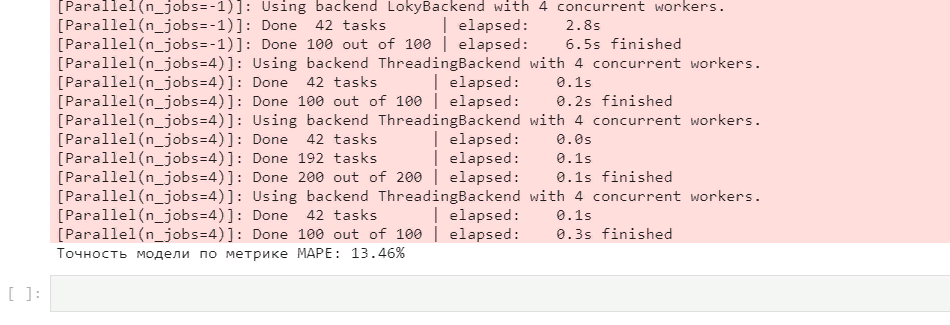

# Submission

In [313]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,596364.81
1,1100549428,908970.56
2,1100658222,847282.00
3,1100937408,709222.62
4,1101037972,701398.62
5,1100912634,774565.62
6,1101228730,599294.12
7,1100165896,370734.41
8,1100768262,1751518.62
9,1101218501,792550.62


In [319]:
sample_submission.shape

(34686, 2)

# Выводы

95% времени заняли парсинг и очистка данных. Из-за этого, к сожалению, остальные разделы проекта пришлось "скомкать". Тем не менее некоторые моменты можно отметить.

* CatBoost выдает лучшие метрики (RMSE и коэф.детерминации), нежели модели, рекомендуемые Lazy Predict. Однако, метрика МАРЕ у CatBoost получается ниже, чем у XGBRegressor.
* Лучший результат дала модель на основе XGBRegressor: 12.93% на валидационной выборке и 13.16% на ЛБ в Kaggle.

Что можно улучшить:
* Спарсить больше свежих данных (времени хватило примерно на 3600 записей).
* Очистку начать с целевой переменной. Удаляем строки с пропусками в целевой переменной = удаляем потенциальный мусор в других переменных. 
* Поиграть с преобразованием переменных: логарифмирование, стандартизация, очистка от выбросов и пр.
* Убрать мультиколлинеарность.
